# The datasets

The datasets parkering2018.csv and parkering2017.csv contain data about the **hourly occupancy precentage** for 9 different parking lots in Stavanger. The data is open to the public, and can be found using the links below: 

- [Parking 2017](https://data.norge.no/nb/datasets/324aa45a-6797-4913-b0f7-642bf12e5b8f)
- [Parking 2018](https://data.norge.no/nb/datasets/0b3586a1-c740-4c60-ae4a-6be92845d5a6)


Both datasets have the same columns, and are structured the same way:
- `Dato` contains the date, format 'dd-mnt-17' or 'dd-mnt-18'
- `Tid` - contains the hour of the day, format 'dd:dd'
- `Siddis` - occupancy percentage for this parking lot
- `Forum` - occupancy percentage for this parking lot
- `Jernbanen` - occupancy percentage for this parking lot
- `Posten` - occupancy percentage for this parking lot
- `Jorenholmen` - occupancy percentage for this parking lot
- `St. Olav` - occupancy percentage for this parking lot
- `Valberget` - occupancy percentage for this parking lot
- `Kyrre` - occupancy percentage for this parking lot
- `Parketten` - occupancy percentage for this parking lot

## Challenges with the datasets

The first thing we notice, is that the date and time columns are not in what we would call a standard format. A quick test confirms the suspicion: it's not direclty possible to convert the date to a `datetime` object without preprocessing. We'll need to clean the formatting to enable this. 

The `Tid` column contains values such as `0:00`, `1:00`, ..,`22:00`, `23:00`, with one expection: **Feb 15th 2017** has an entry at `02:01` , but not `02:00`. If left as is, it will create issues when we later want to group the data on hour. Therefore we will replace the problematic value with 02:00. 

Other than that, the datasets are clean and well-structured. 

## Preliminaries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

#some variables that will be useful later on:
parkinglots = ['Siddis', 'Forum', 'Jernbanen', 'Posten', 'Jorenholmen', 'St. Olav', 'Valberget', 'Kyrre', 'Parketten']
colors = ['teal', 'green', 'red', 'blue', 'grey', 'purple', 'orange', 'yellow', 'pink']
colors2 = ['red', 'pink', 'teal', 'orange', 'purple', 'grey', 'blue', 'green', 'green']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
hours = ['00','01','02','03','04','05','06','07','08','09', '10','11','12','13','14','15','16','17','18','19','20','21','22','23']
hours_every_other = ['00','','02','','04','','06','','08','','10','','12','','14', '','16','','18','','20','','22', '']
hours_every_four = ['','01','','','','05','','','','09','','','','13','','','','17','','','','21','', '']


def fix_date(date):
    '''
    A helper function that reformats the Dates to a format that can then be converted to a datetime object
    '''
    day = str(date[0])
    month= str(date[1])
    year = '20' + str(date[2])
    
    if month == 'mai':
        month = 'may'
    elif month == 'okt':
        month = 'oct'
    elif month == 'des':
        month = 'dec'
    return year + '-' + month + '-' + day

## 2018: reading and cleaning

In [2]:
parkering2018 = pd.read_csv('parkering2018.csv')
parkering2018.head()

,Dato,Tid,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten
0,1-jan-18,0:00,"3,0","0,0","19,0","11,0","17,0","22,0","12,0","14,0","13,0"
1,1-jan-18,1:00,"3,0","0,0","18,0","5,0","14,0","21,0","10,0","15,0","13,0"
2,1-jan-18,2:00,"2,0","0,0","17,0","6,0","15,0","21,0","6,0","15,0","4,0"
3,1-jan-18,3:00,"2,0","0,0","17,0","5,0","15,0","21,0","6,0","15,0","3,0"
4,1-jan-18,4:00,"2,0","0,0","17,0","5,0","15,0","21,0","6,0","15,0","3,0"


In [3]:
#Fixing the dates, and adding date+time in a seperate column as a datetime object
parkering2018['Dato'] = parkering2018['Dato'].str.split('-')
parkering2018['Tidspunkt'] = parkering2018['Dato'].apply(fix_date) + ' ' + parkering2018['Tid'] #collecting date + time into a separate column
parkering2018['Tidspunkt'] = pd.to_datetime(parkering2018['Tidspunkt']) #converting the new column to datetime

# Converting the numericals to ratios (floating numbers between 0 and 1)
for lot in parkinglots:
    parkering2018[lot] = parkering2018[lot].str.replace(',','.')
    parkering2018[lot] = parkering2018[lot].astype('float32')
    parkering2018[lot] = parkering2018[lot]/100

#adding a couple of extra columns for future ease. No new information here, just a better setup for visualisations below
parkering2018['Month'] = parkering2018['Tidspunkt'].dt.month # jan=1, ..., dec=12
parkering2018['Hour'] = parkering2018['Tid'].str.split(':').str[0].astype('int32')

#previewing the final dataframe:
parkering2018.head()

C:\Users\lenelise\AppData\Local\Temp\ipykernel_19540\3330570043.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parkering2018['Tidspunkt'] = pd.to_datetime(parkering2018['Tidspunkt']) #converting the new column to datetime


,Dato,Tid,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten,Tidspunkt,Month,Hour
0,"[1, jan, 18]",0:00,0.03,0.0,0.19,0.11,0.17,0.22,0.12,0.14,0.13,2018-01-01 00:00:00,1,0
1,"[1, jan, 18]",1:00,0.03,0.0,0.18,0.05,0.14,0.21,0.10,0.15,0.13,2018-01-01 01:00:00,1,1
2,"[1, jan, 18]",2:00,0.02,0.0,0.17,0.06,0.15,0.21,0.06,0.15,0.04,2018-01-01 02:00:00,1,2
3,"[1, jan, 18]",3:00,0.02,0.0,0.17,0.05,0.15,0.21,0.06,0.15,0.03,2018-01-01 03:00:00,1,3
4,"[1, jan, 18]",4:00,0.02,0.0,0.17,0.05,0.15,0.21,0.06,0.15,0.03,2018-01-01 04:00:00,1,4


## 2017: reading and cleaning

In [4]:
parkering2017 = pd.read_csv('parkering2017.csv')
parkering2017['Dato'] = parkering2017['Dato'].str.split('-')
# print(parkering2017.isna().sum())
parkering2017 = parkering2017.dropna() #one row with pure NaN
parkering2017.head()

,Dato,Tid,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten
0,"[1, jan, 17]",0:00,"2,0","0,0","16,0","15,0","15,0","21,0","8,0","18,0","4,0"
1,"[1, jan, 17]",1:00,"2,0","0,0","11,0","6,0","12,0","19,0","7,0","17,0","4,0"
2,"[1, jan, 17]",2:00,"2,0","0,0","11,0","4,0","12,0","18,0","6,0","18,0","4,0"
3,"[1, jan, 17]",3:00,"2,0","0,0","11,0","3,0","12,0","18,0","6,0","17,0","4,0"
4,"[1, jan, 17]",4:00,"2,0","0,0","11,0","2,0","12,0","17,0","5,0","17,0","4,0"


In [5]:
# # Feb 15th have a registration at 02:01 instead of 02:00
parkering2017['Tid'] = parkering2017['Tid'].replace({
    '2:01': '2:00'
})

parkering2017['Tid'].unique() #validating the fix

array(['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00',
       '8:00', '9:00', '10:00', '11:00', '12:00', '13:00', '14:00',
       '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00',
       '22:00', '23:00'], dtype=object)

In [6]:
parkering2017['Tidspunkt'] = parkering2017['Dato'].apply(fix_date) + ' ' + parkering2017['Tid']
parkering2017['Tidspunkt'] = pd.to_datetime(parkering2017['Tidspunkt'])

for lot in parkinglots:
    parkering2017[lot] = parkering2017[lot].str.replace(',','.')
    parkering2017[lot] = parkering2017[lot].astype('float32')
    parkering2017[lot] = parkering2017[lot]/100


parkering2017['Month'] = parkering2017['Tidspunkt'].dt.month # jan=1, ..., dec=12
parkering2017['Hour'] = parkering2017['Tid'].str.split(':').str[0].astype('int32')

#previewing final dataframe:
parkering2017.head()

C:\Users\lenelise\AppData\Local\Temp\ipykernel_19540\139626249.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parkering2017['Tidspunkt'] = pd.to_datetime(parkering2017['Tidspunkt'])


,Dato,Tid,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten,Tidspunkt,Month,Hour
0,"[1, jan, 17]",0:00,0.02,0.0,0.16,0.15,0.15,0.21,0.08,0.18,0.04,2017-01-01 00:00:00,1,0
1,"[1, jan, 17]",1:00,0.02,0.0,0.11,0.06,0.12,0.19,0.07,0.17,0.04,2017-01-01 01:00:00,1,1
2,"[1, jan, 17]",2:00,0.02,0.0,0.11,0.04,0.12,0.18,0.06,0.18,0.04,2017-01-01 02:00:00,1,2
3,"[1, jan, 17]",3:00,0.02,0.0,0.11,0.03,0.12,0.18,0.06,0.17,0.04,2017-01-01 03:00:00,1,3
4,"[1, jan, 17]",4:00,0.02,0.0,0.11,0.02,0.12,0.17,0.05,0.17,0.04,2017-01-01 04:00:00,1,4


# Visualization

## Hourly averages

We start of this journey of playfullness and experimentation by investigating the hourly averages for the different parking lots, and years. 

The overall goal is to see if there are times during a day when the occupancy percentage of the parking lot are higher than others, and possibly if this has changed from 2017 to 2018.

### Hourly averages 2018

In [7]:
#Hourly averages for each lot for each year
parkinglots_hourly_avg_2017 = [] # List of Series objects, one for each lot
parkinglots_hourly_avg_2018 = [] # List of Series objects, one for each lot

for lot in parkinglots: 
    parkinglots_hourly_avg_2017.append(parkering2017.groupby('Hour')[lot].mean().sort_index()) #sort index to make sure it is plotted in correct order
    parkinglots_hourly_avg_2018.append(parkering2018.groupby('Hour')[lot].mean().sort_index())

#just to see how each element in the lists looks like: 
# parkinglots_hourly_avg_2017[1]

This first plot is just for fun. It is honestly not meant to show anything at all, though what we are in fact able to observe is that there some to be a higher occupancy precentage during daytime compared to nighttime.

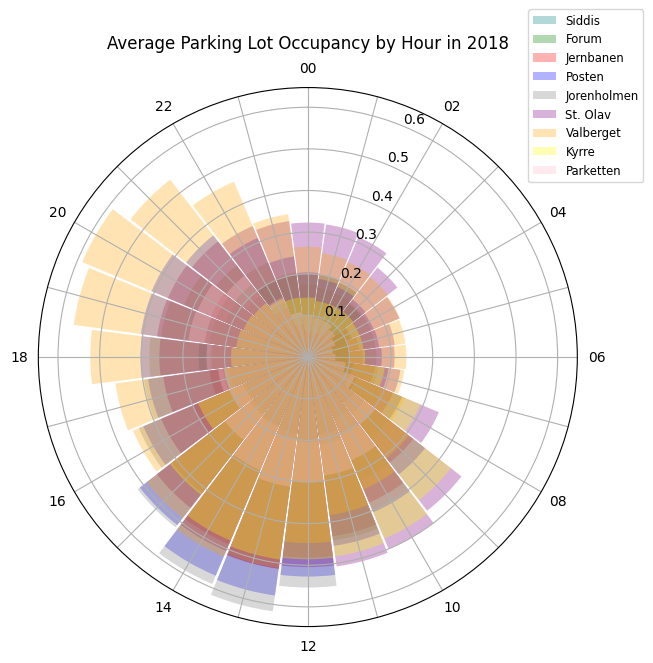

In [8]:
angles = np.linspace(0, 2 * np.pi, 24, endpoint=False) #deler opp sirkel (2*pi) i 24 like store deler

fig, ax = plt.subplots(figsize=(7,7), subplot_kw={'projection': 'polar'})

i=0
for lot_avg in parkinglots_hourly_avg_2018:
    bars = ax.bar(angles, parkinglots_hourly_avg_2018[i].values, width=0.25, color=colors[i], alpha=0.3, label=parkinglots[i]) #alpha styrer gjennomsiktighetsgraden
    i += 1

ax.legend(loc='best', fontsize='small', bbox_to_anchor=(1,1), bbox_transform = fig.transFigure) #plasseres ut fra figurens akser, ikke Axes' akser
ax.set_title("Average Parking Lot Occupancy by Hour in 2018", va='bottom')
ax.set_xticks(angles)
ax.set_xticklabels(hours_every_other)

ax.set_theta_direction(-1)       # Clockwise
ax.set_theta_zero_location("N")  # 12 o'clock starts at top

plt.show()

In [9]:
# parkering2018.describe()

Below is the same plot as above, but with one separate plot for each parking lot. We have made sure that the r-axis is the same for all plots, so we should be able to see both how the average occupancy is at different times *and* the occupancy precentage size compared between the parking lots. 

Observe that
- St.Olav and Forum seem to have more cars around the clock that for example Jernbanen or Jorenholden
- Kyrre has only a small part of the day with a significatn number of cars, which seems to be between 9 AM and 15 PM
- The parking lots that seems to be most used, at least in terms of precentage used, is St.Olav, Posten and Valberget

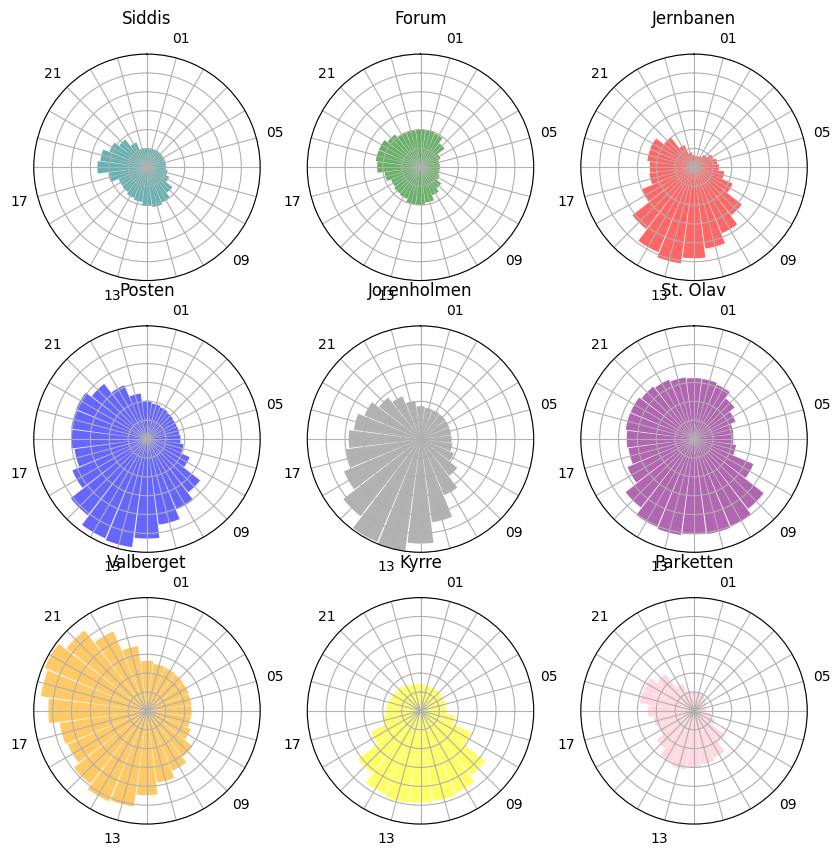

In [10]:
fig, ax = plt.subplots(3,3,figsize=(10,10), subplot_kw={'projection': 'polar'}, squeeze=False)

i = 0
j = 0
for k in range(9):
    ax[i,j].bar(angles, parkinglots_hourly_avg_2018[k].values, width=0.25, color=colors[k], alpha=0.6, label=parkinglots[k]) #alpha styrer gjennomsiktighetsgraden
    ax[i,j].set_title(parkinglots[k])
    
    ax[i,j].set_xticks(angles)
    ax[i,j].set_xticklabels(hours_every_four)
    # ax[i,j].set_xticklabels([])
    ax[i,j].set_yticklabels([])

    ax[i,j].set_rlim(0,0.6) #fixing the r-axis so all subplots have the same

    ax[i,j].set_theta_direction(-1)       # Clockwise
    ax[i,j].set_theta_zero_location("N")  # 12 o'clock starts at top

    j += 1

    if j == 3:
        i += 1
        j = 0

plt.show()

To get a clearer picture, or at least another picture of the same data as above, we plotted the corresponding bar charts of the hourly occupancy averages for each parking lot. 

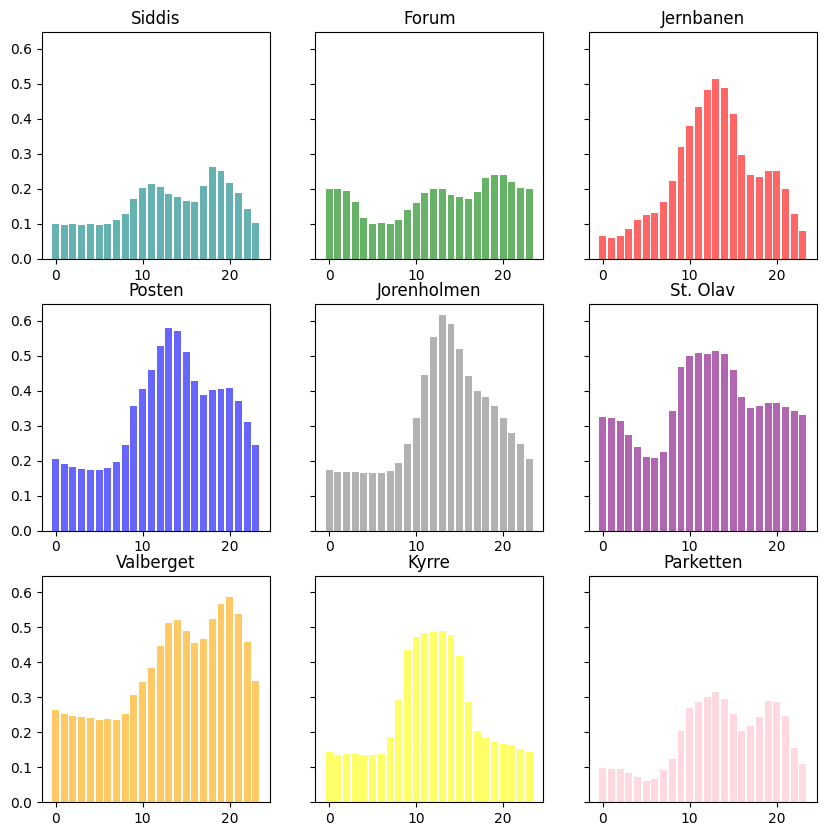

In [11]:
fig, ax = plt.subplots(3,3,figsize=(10,10), sharey=True)

n_bins = 24
i = 0
j = 0
for k in range(9):
    ax[i,j].bar(parkinglots_hourly_avg_2018[k].index, parkinglots_hourly_avg_2018[k].values, color=colors[k], alpha=0.6, label=parkinglots[k]) #alpha styrer gjennomsiktighetsgraden    
    ax[i,j].set_title(parkinglots[k])

    j += 1
    if j == 3:
        i += 1
        j = 0

plt.show()

Comparing 2017 and 2018. 
Not fixed r axis because we want to compare each lot with itself over the two years, not make any comparisons between the lots

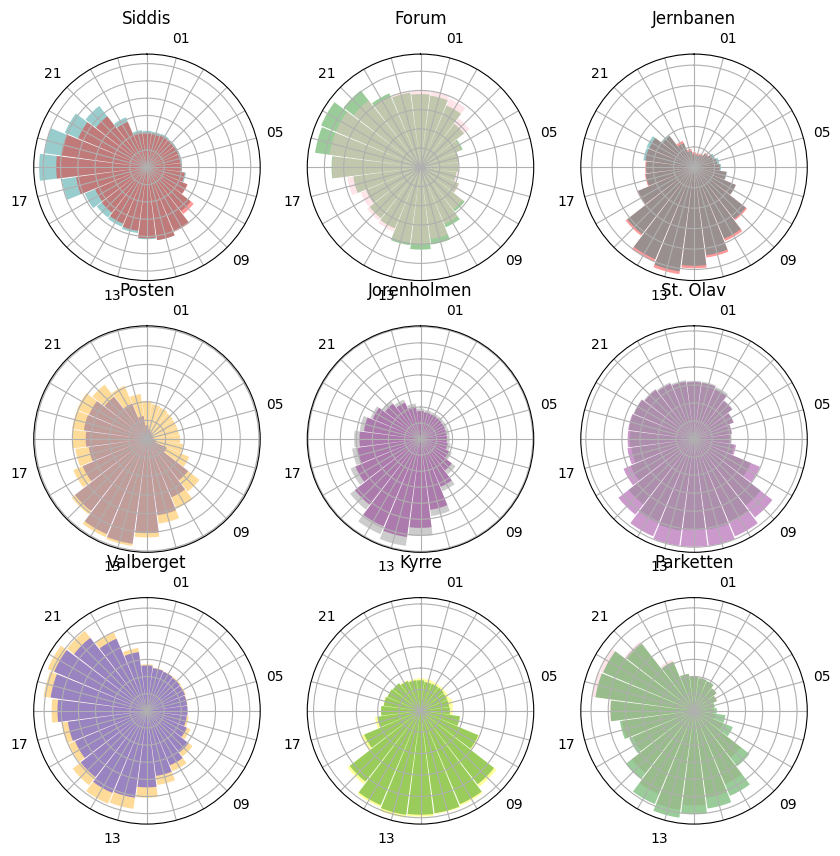

In [12]:
fig, ax = plt.subplots(3,3,figsize=(10,10), subplot_kw={'projection': 'polar'}, squeeze=False)

i = 0
j = 0
for k in range(9):
    ax[i,j].bar(angles, parkinglots_hourly_avg_2017[k].values, width=0.25, color=colors[k], alpha=0.4, label=parkinglots[k]) #alpha styrer gjennomsiktighetsgraden
    ax[i,j].bar(angles, parkinglots_hourly_avg_2018[k].values, width=0.25, color=colors2[k], alpha=0.4, label=parkinglots[k]) #alpha styrer gjennomsiktighetsgraden
    ax[i,j].set_title(parkinglots[k])
    
    ax[i,j].set_xticks(angles)
    ax[i,j].set_xticklabels(hours_every_four)
    # ax[i,j].set_xticklabels([])
    ax[i,j].set_yticklabels([])

    # ax[i,j].set_rlim(0,0.6) #fixing the r-axis so all subplots have the same

    ax[i,j].set_theta_direction(-1)       # Clockwise
    ax[i,j].set_theta_zero_location("N")  # 12 o'clock starts at top

    j += 1

    if j == 3:
        i += 1
        j = 0

plt.show()

# Case study: Forum

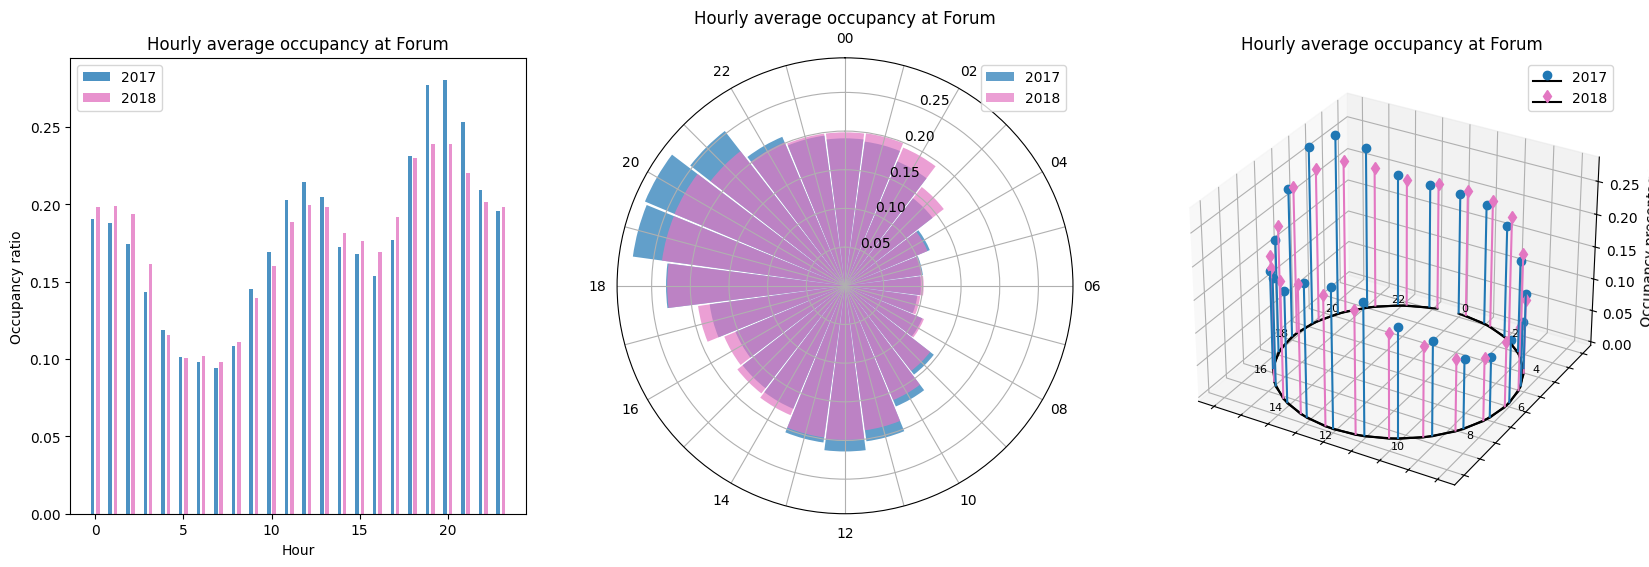

In [192]:
fig = plt.figure(figsize=(20, 10)) 
color = 'C6'

#################################
#### PLOT 1: simple bar chart 
################################

ax2 = fig.add_subplot(1,3,1)
ax2.set_box_aspect(1)
w, x = 0.3, np.arange(24)

ax2.bar(x-w/2, parkinglots_hourly_avg_2017[1].values, label='2017', width=0.2, alpha=0.8)
ax2.bar(x+w/2, parkinglots_hourly_avg_2018[1].values, label='2018', width=0.2, alpha=0.8, color=color)

# ax2.set_xticks(ticks=x, labels=months[:-1])
ax2.set_xlabel('Hour')
ax2.set_ylabel('Occupancy ratio')
ax2.set_title("Hourly average occupancy at Forum")
ax2.legend()

#############################
#### Plot 1: polar
#############################
ax0 = fig.add_subplot(1,3,2,projection='polar')

bars = ax0.bar(angles, parkinglots_hourly_avg_2017[1].values, width=0.25, alpha=0.7, label='2017') #alpha styrer gjennomsiktighetsgraden
bars = ax0.bar(angles, parkinglots_hourly_avg_2018[1].values, width=0.25, color=color, alpha=0.7, label ='2018') #alpha styrer gjennomsiktighetsgraden

ax0.legend(loc='best') #plasseres ut fra figurens akser, ikke Axes' akser
ax0.set_theta_zero_location("N")  # 12 o'clock starts at top
ax0.set_theta_direction(-1)       # Clockwise
ax0.set_xticks(angles)
ax0.set_xticklabels(hours_every_other)
ax0.set_title("Hourly average occupancy at Forum")

###########################
#### Plot 2: 3D
###########################

ax1 = fig.add_subplot(1,3,3,projection='3d')

x1 = np.sin(np.linspace(0, 2 * np.pi, 24, endpoint=False)) 
y1 = np.cos(np.linspace(0, 2 * np.pi, 24, endpoint=False)) 
z1 = parkinglots_hourly_avg_2017[1].values

d = 0.07 #want the 2018 stems to be close to 2017, but not at the same exact spot
x2 = np.sin(np.linspace(0 + d, 2 * np.pi + d, 24, endpoint=False)) 
y2 = np.cos(np.linspace(0 + d, 2 * np.pi + d, 24, endpoint=False)) 
z2 = parkinglots_hourly_avg_2018[1].values

ax1.stem(x1,y1,z1, 
        basefmt = 'k-',
        label='2017')

ax1.stem(x2,y2,z2, 
        linefmt = f'{color}-', #vertical line
        markerfmt=f'{color}d', #stem head
        basefmt='k-', #baseline
        label='2018')

# ax.set_xticks(angles)
# ax.set_xticklabels(hours_every_four
ax1.legend(loc='best') #plasseres ut fra figurens akser, ikke Axes' akser
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zlabel("Occupancy precentage")
ax1.set_title("Hourly average occupancy at Forum")

for i, (xi, yi) in enumerate(zip(x1, y1)):
    if i%2==0:
            ax1.text(xi * 1.1, yi * 1.1, 0, str(i), ha='center', va='center', fontsize=8)

plt.show()

# 3D plots (??)

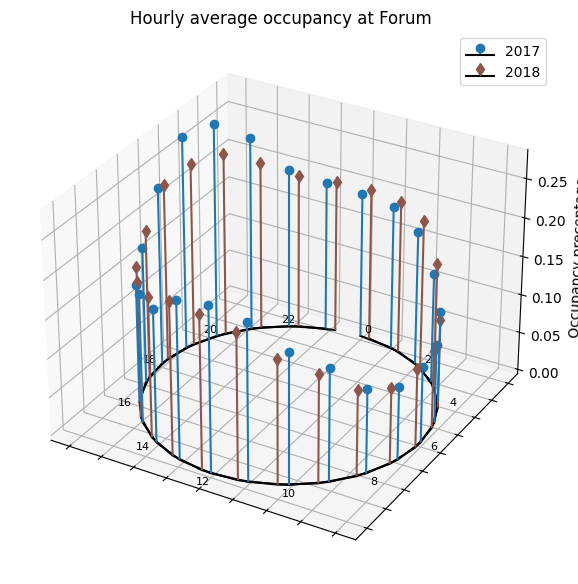

In [112]:
fig, ax = plt.subplots(figsize=(7,9),subplot_kw={'projection': '3d'})

x1 = np.sin(np.linspace(0, 2 * np.pi, 24, endpoint=False)) #deler opp sirkel (2*pi) i 24 like store deler
y1 = np.cos(np.linspace(0, 2 * np.pi, 24, endpoint=False)) #deler opp sirkel (2*pi) i 24 like store deler
z1 = parkinglots_hourly_avg_2017[1].values

d = 0.07 #want the 2018 stems to be close to 2017, but not at the same exact spot
x2 = np.sin(np.linspace(0 + d, 2 * np.pi + d, 24, endpoint=False)) #deler opp sirkel (2*pi) i 24 like store deler
y2 = np.cos(np.linspace(0 + d, 2 * np.pi + d, 24, endpoint=False)) #deler opp sirkel (2*pi) i 24 like store deler
z2 = parkinglots_hourly_avg_2018[1].values

ax.stem(x1,y1,z1, 
        basefmt = 'k-',
        label='2017')

color = 'C5'
ax.stem(x2,y2,z2, 
        linefmt = f'{color}-', #vertical line
        markerfmt=f'{color}d', #stem head
        basefmt='k-', #baseline
        label='2018')

# ax.set_xticks(angles)
# ax.set_xticklabels(hours_every_four)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zlabel("Occupancy precentage")

ax.set_title("Hourly average occupancy at Forum")

ax.legend()

for i, (xi, yi) in enumerate(zip(x1, y1)):
    if i%2==0:
            ax.text(xi * 1.1, yi * 1.1, 0, str(i), ha='center', va='center', fontsize=8)

plt.show()

# Conclusions

As mentioned in the README, I have close to no knowledge about Stavanger, its's areas and thus where these parking lots may be. The only parking lot I can say anything about is *Jernbanen*, which I would assume to be close to the central station, and thus also close to the city center. 

From the plots I have made the following hypothesis': 

St.Olav, Forum, Siddis, Posten and Valberget all have 10% or higher occupancy at every hour of the day. So I predict that these are locations where it makes sense that a good amount of people park their cars overnight. For example: 
- hospitals
- hotels/conference hotels
- airports

Kyrre has high occupancy during a short interval during the day, between 10 AM and 15 PM. Maybe this could be near a school, or a larger workplace?

# Trash?

### The same, just in plotly

**Note:** Plotly express does not support multiple traces (graphs) in the same figure. For that we need to use Plotly Graph Objects.

In [13]:
angles360 = np.linspace(0, 360, 24, endpoint=False) #deler opp sirkel (360) i 24 like store deler

fig = px.bar_polar(
    parkering2018,
    r = parkering2018.groupby('Tid')['Siddis'].mean().values,
    theta = angles360, 
    color=parkering2018.groupby('Tid')['Siddis'].mean().values
)

fig.update_traces(overwrite=True, marker={"opacity": 0.4})

fig.show()

### 2017 vs 2018

We will try to see if there has been any exciting changes in the hourly averages from 2017 and 2018. 

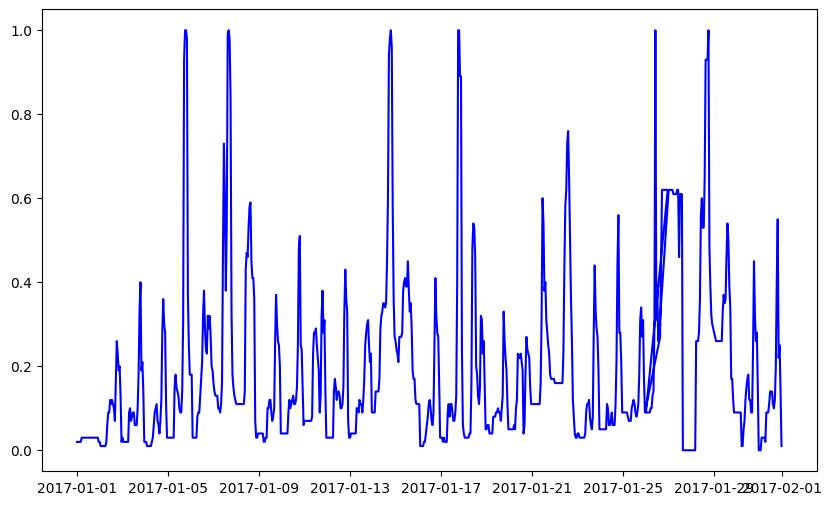

In [14]:
jan2017 = parkering2017[ parkering2017['Tidspunkt'].dt.month == 1]
x1 = jan2017['Tidspunkt']
x2 = parkering2018['Tidspunkt']

y1 = jan2017['Siddis']
y2 = parkering2018['Siddis']

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(x1,y1,'b')
# ax.plot(x2,y2,'b')

plt.show()

## St Olavs 2017 vs 2018

After cheating, and checking out some graphs in Power Bi, I decided to take a closer look at St.Olav. 

This is only beause this is the only parking lot where anything exciting happened between 2017 and 2018: the hourerly average coverage went significantly down. 

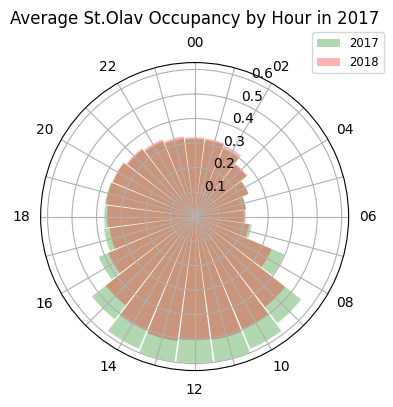

In [ ]:
Forum_hour_average_2017 = parkering2017.groupby('Hour')['St. Olav'].mean().sort_index()
Forum_hourly_average_2018 = parkering2018.groupby('Hour')['St. Olav'].mean().sort_index()

fig, ax = plt.subplots(figsize=(4,4), subplot_kw={'projection': 'polar'})

bars = ax.bar(angles, Forum_hour_average_2017, width=0.25, color=colors[1], alpha=0.3, label='2017') #alpha styrer gjennomsiktighetsgraden
bars = ax.bar(angles, Forum_hourly_average_2018, width=0.25, color=colors[2], alpha=0.3, label ='2018') #alpha styrer gjennomsiktighetsgraden

ax.legend(loc='best', fontsize='small', bbox_to_anchor=(1,0.97), bbox_transform = fig.transFigure) #plasseres ut fra figurens akser, ikke Axes' akser

# Optional: Customize
ax.set_theta_zero_location("N")  # 12 o'clock starts at top
ax.set_theta_direction(-1)       # Clockwise
ax.set_xticks(angles)
ax.set_xticklabels(hours_every_other)
ax.set_title("Average St.Olav Occupancy by Hour in 2017", va='bottom')

plt.show()

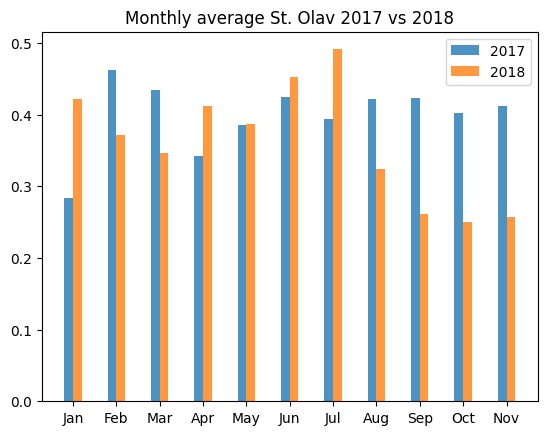

In [ ]:
## St. Olav occupancy by monthly averages
Forum_hour_average_2017 = parkering2017.groupby('Month')['St. Olav'].mean()
Forum_hourly_average_2018 = parkering2018.groupby('Month')['St. Olav'].mean() #2018 mangler data for desember

fig,ax = plt.subplots()

w, x = 0.2, np.arange(len(months)-1)

# ax.bar(months[:-1], siddis_monthly_average_2017.values[:-1], label='2017', width=0.2, alpha=0.5)
# ax.bar(months[:-1], siddis_monthly_average_2018.values, label='2018', width=0.2, alpha=0.5)
ax.bar(x-w/2, Forum_hour_average_2017.values[:-1], label='2017', width=0.2, alpha=0.8)
ax.bar(x+w/2, Forum_hourly_average_2018.values, label='2018', width=0.2, alpha=0.8)

ax.set_xticks(ticks=x, labels=months[:-1])
ax.set_title("Monthly average St. Olav 2017 vs 2018")
ax.legend()

plt.show()